# Pre-processing and analysis of the dataset

In [1]:
import pymongo
import os

import string
import re
import textacy.preprocessing as tprep

import numpy as np
import pandas as pd

import fasttext
import spacy
from spacy.language import Language
from spacy import displacy

from sklearn.utils import shuffle

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

## 1. Retrieving the data from the database

In [359]:
mg_host = os.environ.get("MONGO_HOST")
mg_username = os.environ.get("MONGO_USER")
mg_password = os.environ.get("MONGO_PW")
client = pymongo.MongoClient(f'mongodb://{mg_username}:{mg_password}@{mg_host}')

cvs = client.badtranslator.cvs

## 2. Creation and pre-processing of the dataset

In [360]:
def mongo_to_pandas(db_coll, chunksize = 100, no_id=True):

    # Size of chunks
    skips_variable = range(0, db_coll.count_documents({}), int(chunksize))
    
    if len(skips_variable)<=1:
        skips_variable = [0,len(skips_variable)]

    for i in range(0, len(skips_variable)):
        
        if (skips_variable.stop - i * skips_variable.step < skips_variable.step):
            df_aux =pd.DataFrame(list(db_coll.find()[skips_variable[i]:skips_variable.stop+1]))
        else:                    
            df_aux =pd.DataFrame(list(db_coll.find()[skips_variable[i]:skips_variable[i+1]]))

        if no_id:
            del df_aux['_id']

        if 'df' not in locals():
            df =  df_aux
        else:
            df = pd.concat([df, df_aux], ignore_index=True)

    return df

In [361]:
df = mongo_to_pandas(cvs)

In [362]:
print(df.count())

email      812
cv        1541
status    1541
name       729
dtype: int64


Are there colums with null values beside 'email' and 'name'? **No**

In [363]:
for col in df.columns:
    print(col, df[col].isnull().sum())

email 729
cv 0
status 0
name 812


Language detection, because we only want resumes in English!

In [364]:
pretrained_model = "lid.176.bin" 
# Size: 129MB  , Download: https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin
model = fasttext.load_model(pretrained_model)
langs = []

for item in df['cv']:
    item = item.replace("\n"," ")
    lang = model.predict(item)[0]
    langs.append(str(lang)[11:13])

df['lang'] = langs

In [365]:
df.loc[~df['lang'].isin(['en', 'ca', 'uk'])].sample(10)

,email,cv,status,name,lang
1361,NaN,Patricia Fierro Carrin \nPares de idiomas: \ni...,good,Patricia FierroM. Sc.,es
1457,NaN,cid:0cid:17cid:18cid:19cid:20cid:21cid:22cid:2...,good,ez-Ballina,ru
1229,NaN,M\nM\nA\nA\nR\nR\nA\nA\nA\nA\nG\nG\nU\nU\nI\nI...,good,LSGTranslations,es
1295,NaN,Lebenslauf auf Anfrage \nResume available upon...,good,Michael Ferris,de
1343,NaN,"NICOLA HOLMES \nTraducteur du franais, de lesp...",good,Nicola Holmes,fr
825,NaN,ADELEBLACK\nT R A D U C T O R A \nI N T R P R...,good,ele Black,es
1070,NaN,Informations personnelles : \nPrnom : \nNom de...,good,Helen Blair,fr
1151,NaN,Nombre:\nJos Manuel Pez Salinas\nFecha de Naci...,good,Jose Paez,es
1127,NaN,"JOEL PIA DIAZ \nMdico, miembro FACS \nTrabajo ...",good,Joel Pina Diaz,es
967,NaN,"David Tracey PhD, DipTrans IoL \nFreiberuflich...",good,TraceyPhD,de


*References*

@article{joulin2016bag,
  title={Bag of Tricks for Efficient Text Classification},
  author={Joulin, Armand and Grave, Edouard and Bojanowski, Piotr and Mikolov, Tomas},
  journal={arXiv preprint arXiv:1607.01759},
  year={2016}
}

We filter these records.

In [366]:
df_filtered = df.loc[df['lang'].isin(['en', 'ca', 'uk'])]

Shuffling of the dataset, because of the label bias of the original dataset.

In [367]:
df_filtered = df_filtered.sample(frac=1).reset_index(drop=True)

Removing the not needed columns

In [368]:
df_filtered.drop(["email"], axis=1, inplace=True)
df_filtered.drop(["name"], axis=1, inplace=True)
df_filtered.drop(["lang"], axis=1, inplace=True)

In [369]:
df_filtered.sample(5).T

,64,1239,1355,28,280
cv,mh \n Michael Hariton \n735 W183rd Street New ...,"LUIS J. QUIRINDONGO RODRGUEZ \nTranslator, Pro...",Robert Rutledge \nSpanish to English Translato...,"Lina Hamid \n78 Ali Moawad St., AlBarageel Roa...",CURRICULUM VITAE. \nExperienced English <> Kor...
status,good,good,good,bad,bad


## 3. Persistent copy of the dataframe

In [370]:
df_filtered.to_pickle("cvs_dataframe.pkl")

In [60]:
df_filtered = pd.read_pickle("cvs_dataframe.pkl")

## 4. Text normalization of column cv

### 4.1 Lowercasing of the cv column

In [61]:
df_filtered['cv'] = df_filtered['cv'].apply(lambda x: x.lower())

### 4.2 Contractions

Are there contractions. Check with "I'm".

In [62]:
contractions = df_filtered.loc[df_filtered['cv'].str.contains("I'm", case=False)]
print(contractions)

                                                     cv status
96    resume\nname :\namanda steive\ngender:\nfemale...    bad
143   yeal leon\naddress: 13 gur yehuda st, tel aviv...    bad
294   john lonergan \njohn lonergan \ntranslations f...   good
308   dk1307 kbenhavn, denmark  catrinekarlsson@outl...    bad
339   fluent in english and swedish  spoken and read...    bad
354   alfie mendez\nmulticultural, all industry inte...   good
459   curriculum vitai \npersonal info \n name : sus...    bad
492   name diana olmec \ngender female\nnationality ...    bad
519   experienced chinesemandarin, japanese, english...    bad
731   curriculum vitae \nemail: ran_kay@hotmail.com ...    bad
788   ian wang \n8year freelance englishchinese tran...    bad
810   curriculum vitae\nmaria bozell\nfreelance tran...    bad
815   a l i t t l e a b o u t m e :\nla cruz a medic...   good
1045  mary mcarthur \n1831 pacific avenue, suite 301...   good
1169  sarah kate michel, fortis green rd, muswell hi...

Fixing contractions: We leave that to the Spacy pipeline for the time being

In [63]:
# import contractions
# df_filtered['cv'] = df_filtered['cv'].apply(lambda x: contractions.fix(x))

### 4.3 Special characters

Cleaning "pipeline"

In [64]:
def clean(text):
    # standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # sequences of white spaces
    text = re.sub(r' {2,}', ' ', text) # We leave the line breaks for the time being
    return text.strip()

In [65]:
df_filtered['cv'] = df_filtered['cv'].apply(lambda x: clean(x))

### 4.4 Punctuation

Removing punctuation: Is this actually needed? 

In [66]:
# df['cv'] = df['cv'].apply(lambda x: ''.join([token for token in x if token not in string.punctuation]))

### 4.5 Textacy pipeline

Textacy pipeline.
We won't mask e-mail adresses and phone numbers, because they convey important information (fakes).

In [67]:
preproc = tprep.make_pipeline(
    tprep.normalize.hyphenated_words, # Removes hyphens at the end of lines
    tprep.normalize.whitespace, # Normalize and strip leading white spaces
    tprep.normalize.quotation_marks, # Normalizes quotation marks
    tprep.normalize.unicode, # Normalizes accented characters for subsequent removal
    tprep.remove.accents # Removes accents
)

In [68]:
df_filtered['cv'] = df_filtered['cv'].apply(lambda x: preproc(x))

## 5. Spacy pipeline preconfiguration

We remove the parser component from the pipeline, because it has problems dealing with the CR/LF of the converted pdfs.

In [69]:
nlp = spacy.load('en_core_web_md', exclude=["parser"])
nlp.enable_pipe("senter")

In [70]:
nlp.pipeline

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x265f828de20>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x265f828d580>),
 ('senter', <spacy.pipeline.senter.SentenceRecognizer at 0x265f828d340>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x265f82f19c0>),
 ('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x265f82effc0>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x265f6fff430>)]

## 6. Processing with Spacy

### 6.1 Removal of stop words

In [71]:
stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [72]:
df_filtered['no_stopwords'] = df_filtered['cv'].apply(
    lambda x: " ".join([token.text for token in nlp.tokenizer(x) if not token.is_stop]))

### 6.2 Tokenization

In [73]:
df_filtered['tokens'] = df_filtered['no_stopwords'].apply(lambda x: [t.text for t in nlp.tokenizer(x) \
if ((len(t.text) > 2) & (re.search(r'^\n\s{2,}$', t.text) is None))])
# len = 2 is an arbitrary setting that leaves special characters and line breaks out

## 7. Analysis

### 7.1 Number of fake vs. legitimate resumes

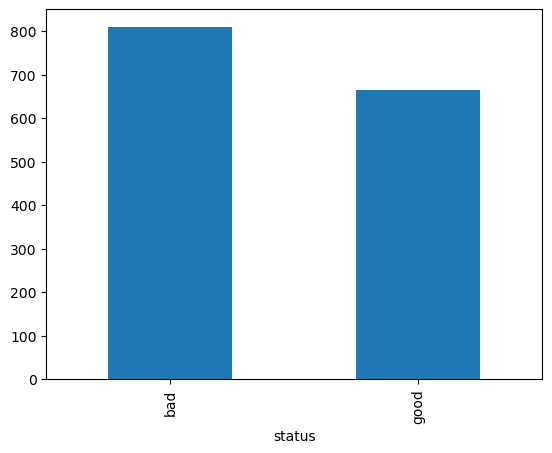

In [74]:
df_filtered.groupby(['status'])['cv'].count().plot(kind="bar")
plt.show()

### 7.2 Word cloud of legitimate resumes

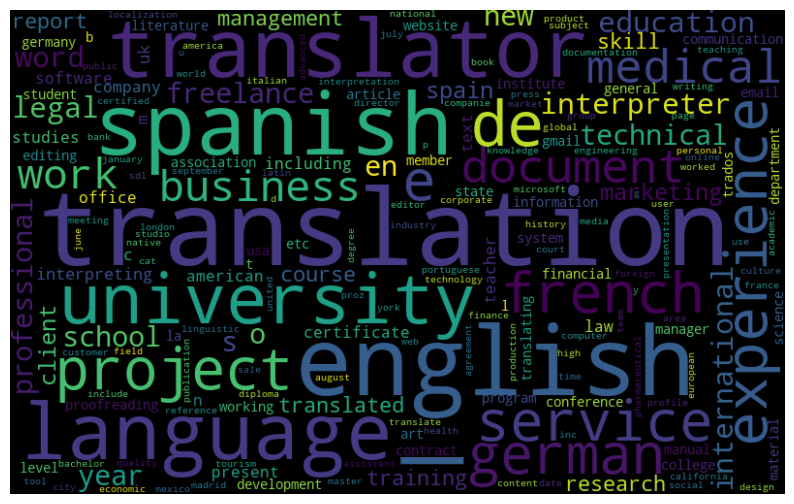

In [75]:
fake_cvs = df_filtered[df_filtered["status"] == "good"]
all_words = ' '.join([text for text in fake_cvs.no_stopwords])
wordcloud = WordCloud(width= 800, height= 500, max_font_size = 110, collocations = False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### 7.3 Word cloud of the fake resumes

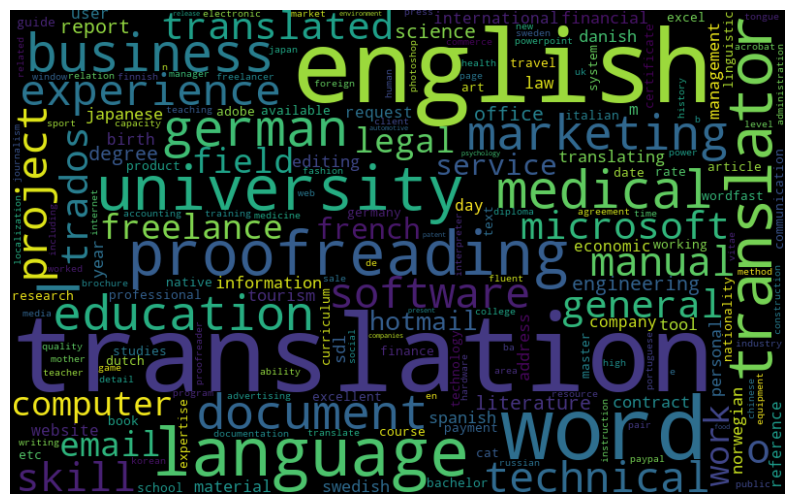

In [76]:
fake_cvs = df_filtered[df_filtered["status"] == "bad"]
all_words = ' '.join([text for text in fake_cvs.no_stopwords])
text_file = open("./all_words.txt", "w")
text_file.write(all_words)
text_file.close()
wordcloud = WordCloud(width= 800, height= 500, max_font_size = 110, collocations = False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Both work clouds look alike. Let's obtain the actual word frequencies of both subsets, "good" (legitimate) and "bad" (fake): 

### 7.4 Word frequency

#### 7.4.1 Word frequency in legitimate CVs

In [77]:
from collections import Counter

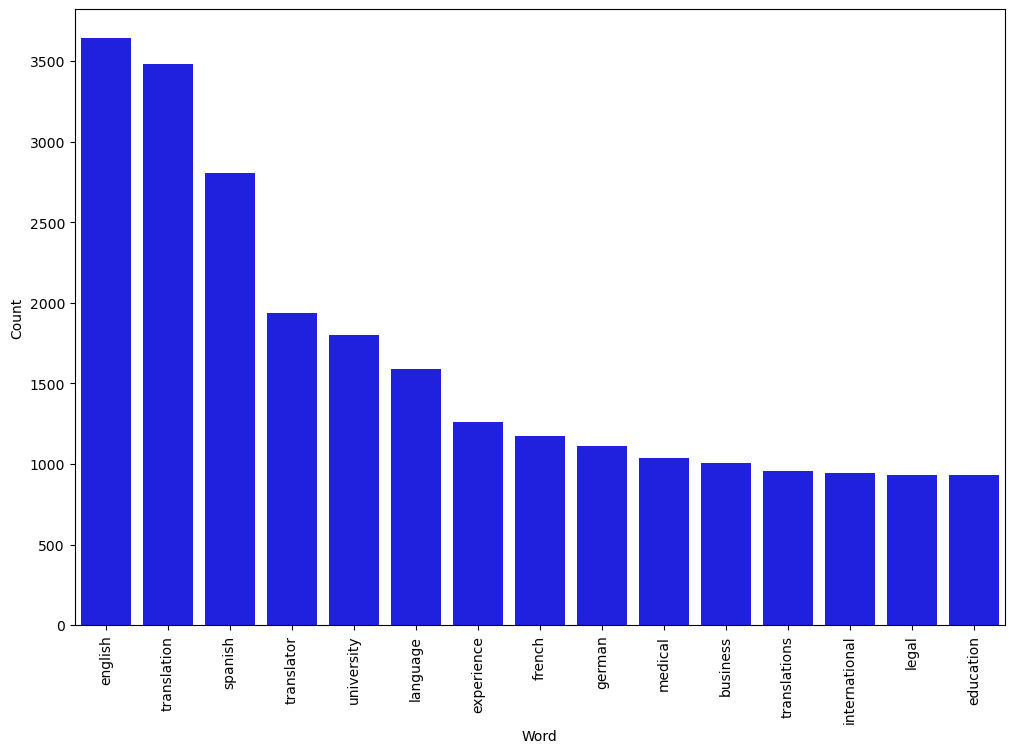

In [78]:
# tokens_good = [word for record in df_filtered[df_filtered["status"] == "good"]['tokens'].to_list() for word in record]
counter = Counter()
df_filtered[df_filtered["status"] == "good"]['tokens'].map(counter.update)
df_frequency = pd.DataFrame.from_dict(counter, orient='index', columns=['Frequency'])
df_frequency.index.name = 'Word'
df_frequency = df_frequency.nlargest(columns = "Frequency", n = 15)

plt.figure(figsize=(12,8))
ax = sns.barplot(data = df_frequency, x = df_frequency.index, y = "Frequency", color = 'blue')
ax.set(ylabel = "Count")
plt.xticks(rotation='vertical')
plt.show()

#### 7.4.2 Word frequency in fake CVs

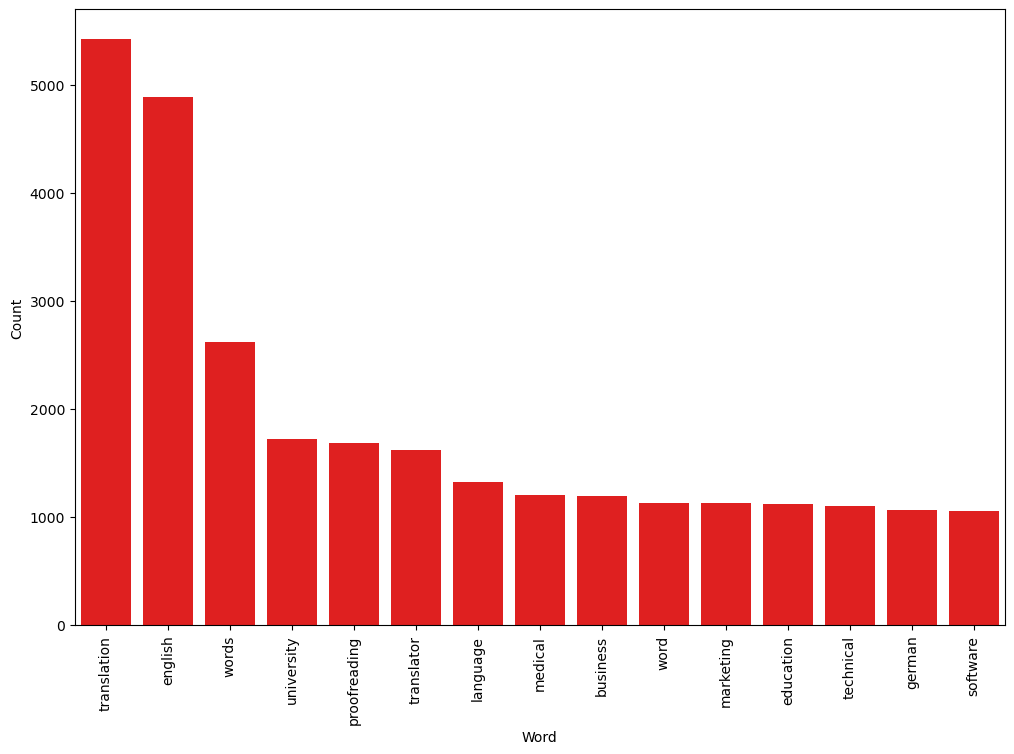

In [79]:
# tokens_bad = [word for record in df_filtered[df_filtered["status"] == "bad"]['tokens'].to_list() for word in record]
counter = Counter()
df_filtered[df_filtered["status"] == "bad"]['tokens'].map(counter.update)
df_frequency = pd.DataFrame.from_dict(counter, orient='index', columns=['Frequency'])
df_frequency.index.name = 'Word'
df_frequency = df_frequency.nlargest(columns = "Frequency", n = 15)

plt.figure(figsize=(12,8))
ax = sns.barplot(data = df_frequency, x = df_frequency.index, y = "Frequency", color = 'red')
ax.set(ylabel = "Count")
plt.xticks(rotation='vertical')
plt.show()

Unfortunately we can't appreciate any special traits in the "bad" subset. The most frequent words are obvious for the analyzed domain, "Translators".

We can resort to the IDF (Inverse Document Frequency), that expresses how "unusual" a term is in a corpus.


### 7.5 Inverse Document Frequency calculation

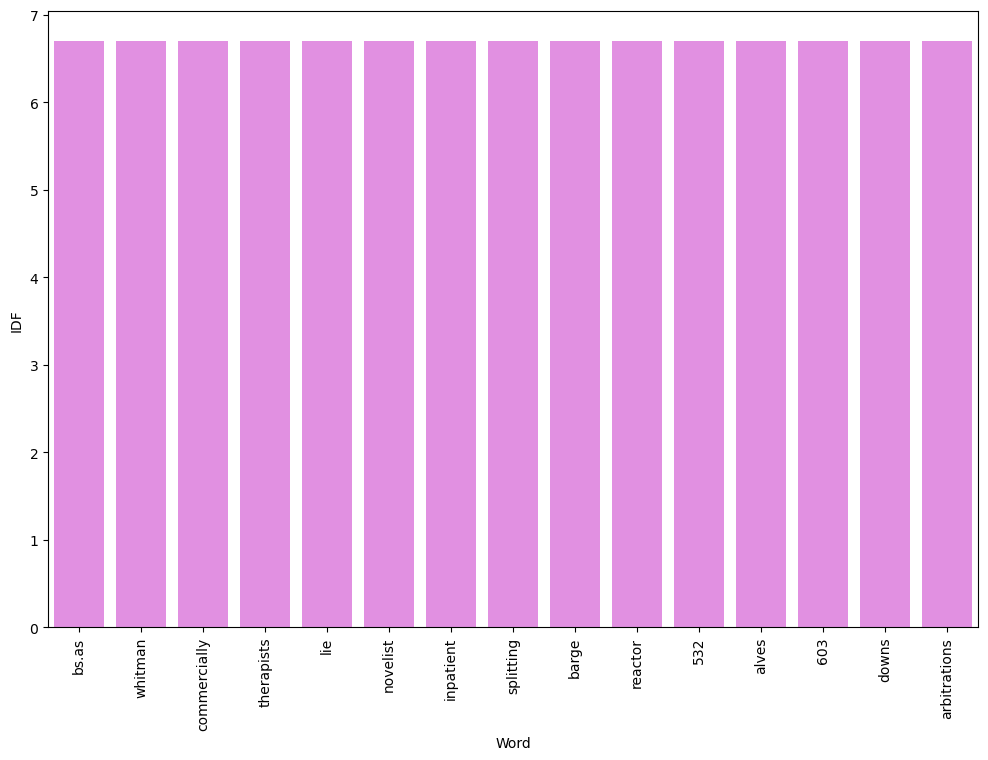

In [89]:
counter = Counter()
min_df = 2

def update(tokens):
    counter.update(set(tokens))

df_filtered['tokens'].map(update)

df_idf = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
df_idf = df_idf.query('df >= @min_df')
df_idf['idf'] = np.log(len(df_filtered)/df_idf['df']) + 0.1
df_idf.index.name = 'Word'
df_idf = df_idf.nlargest(columns = "idf", n = 15)

plt.figure(figsize=(12,8))
ax = sns.barplot(data = df_idf, x = df_idf.index, y = "idf", color = 'violet')
ax.set(ylabel = "IDF")
plt.xticks(rotation='vertical')
plt.show()

## 8. Backup of the normalized dataframe

In [49]:
df_filtered.to_pickle("cvs_dataframe_normalized.pkl")